# Protected Probabilistic Classification

This notebook gives an implementation example of Protected classification for binary classification problems. 

Protected classification is decribed in more detail in:

 - Vovk, Vladimir, Ivan Petej, and Alex Gammerman. "Protected probabilistic classification." In Conformal and Probabilistic Prediction and Applications, pp. 297-299. PMLR, 2021. (arxiv version https://arxiv.org/pdf/2107.01726.pdf)

The Protected Classificaton algorithm can be applied in two ways:

- **batch mode** where we fit it to the training set only and when applied to the test set, the algorithm yields calibrated probability outputs in a similar way to Platt, Isotonic or Venn-Abers calibration
     
- **online mode**, where we assume examples in the test set arrive sequentially and the algorithm protects aagains changes in the underlying data distribution (withiut having to retrain the underlying algorithm)

In this example we focus on the latter (**online mode**) application.

## Import libraries

In [131]:
import pandas as pd
import numpy as np
import sys


from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import metrics

from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

sys.path.append("../") 

from src.protected_classification import (ProtectedClassification, cox_multiclass, gen_alpha, 
                                            generate_protected_params)

import warnings
warnings.filterwarnings('ignore')

## Import dataset

In [132]:
bank = fetch_openml(name='bank-marketing', version=1)
N_train = 10000
N_total = bank.data.shape[0]
N_test = N_total - N_train

In [133]:
df = pd.DataFrame(bank.data)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0.0,unknown
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5.0,may,198.0,1.0,-1.0,0.0,unknown


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      45211 non-null  float64 
 1   V2      45211 non-null  category
 2   V3      45211 non-null  category
 3   V4      45211 non-null  category
 4   V5      45211 non-null  category
 5   V6      45211 non-null  float64 
 6   V7      45211 non-null  category
 7   V8      45211 non-null  category
 8   V9      45211 non-null  category
 9   V10     45211 non-null  float64 
 10  V11     45211 non-null  category
 11  V12     45211 non-null  float64 
 12  V13     45211 non-null  float64 
 13  V14     45211 non-null  float64 
 14  V15     45211 non-null  float64 
 15  V16     45211 non-null  category
dtypes: category(9), float64(7)
memory usage: 2.8 MB


### One hot-encode categorical variables

In [135]:
df = pd.get_dummies(df, ['V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V11', 'V16'])
df.head()

,V1,V6,V10,V12,V13,V14,V15,V2_admin.,V2_blue-collar,V2_entrepreneur,...,V11_jun,V11_mar,V11_may,V11_nov,V11_oct,V11_sep,V16_failure,V16_other,V16_success,V16_unknown
0,58.0,2143.0,5.0,261.0,1.0,-1.0,0.0,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,44.0,29.0,5.0,151.0,1.0,-1.0,0.0,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,33.0,2.0,5.0,76.0,1.0,-1.0,0.0,False,False,True,...,False,False,True,False,False,False,False,False,False,True
3,47.0,1506.0,5.0,92.0,1.0,-1.0,0.0,False,True,False,...,False,False,True,False,False,False,False,False,False,True
4,33.0,1.0,5.0,198.0,1.0,-1.0,0.0,False,False,False,...,False,False,True,False,False,False,False,False,False,True


### Define train and test set

In [136]:
X_train = df[:N_train]  # matrix of training objects
y_train = bank.target[0:N_train].astype(int)    # vector of training labels (as integes)
X_test = df[N_train:] # matrix of test objects
y_test = bank.target[N_train:].astype(int).values    

In [137]:
y_train[y_train==1] = 0
y_train[y_train==2] = 1
y_test[y_test==1] = 0
y_test[y_test==2] = 1

We define a standard binary classification dataset with 10,000 training samples

### The distribution of y-labels

The distribution of y-labels in this datastet is known to be signficantly different between the training and test set (we use this for illustration only, one would not necessarily know this for an unknown test set)

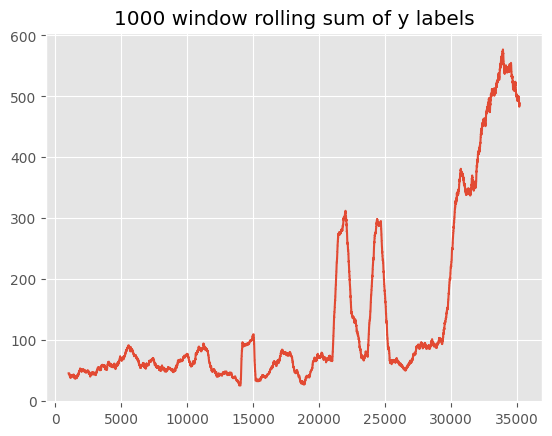

In [138]:
plt.plot(pd.DataFrame(y_test).rolling(1000).sum())
plt.title('1000 window rolling sum of y labels')
plt.show()

We define a Random Forest classifier (with same parameters as in the paper https://arxiv.org/pdf/2107.01726.pdf )

In [139]:
clf = RandomForestClassifier(random_state=2021, n_estimators = 1000).fit(X_train, y_train)

y_pred = clf.predict(X_test)
p_pred = clf.predict_proba(X_test)

### Defining Cox calibrator parameters
note alpha and beta are equal to the default patremeters in the PrrotectedClassification class 

In [140]:
n_classes = 2
betas = [1, 0.5, 2]

protected_params = generate_protected_params(betas, n_classes)

alphas = protected_params[0]

### Plot Cox Calibrators

In [141]:
calibs = [[cox_multiclass([1-i, i], alp, bet) for i in np.linspace(0,1,101)] for alp in alphas for bet in betas]
calib_label = [[str(alp), str(bet)] for alp in alphas for bet in betas]

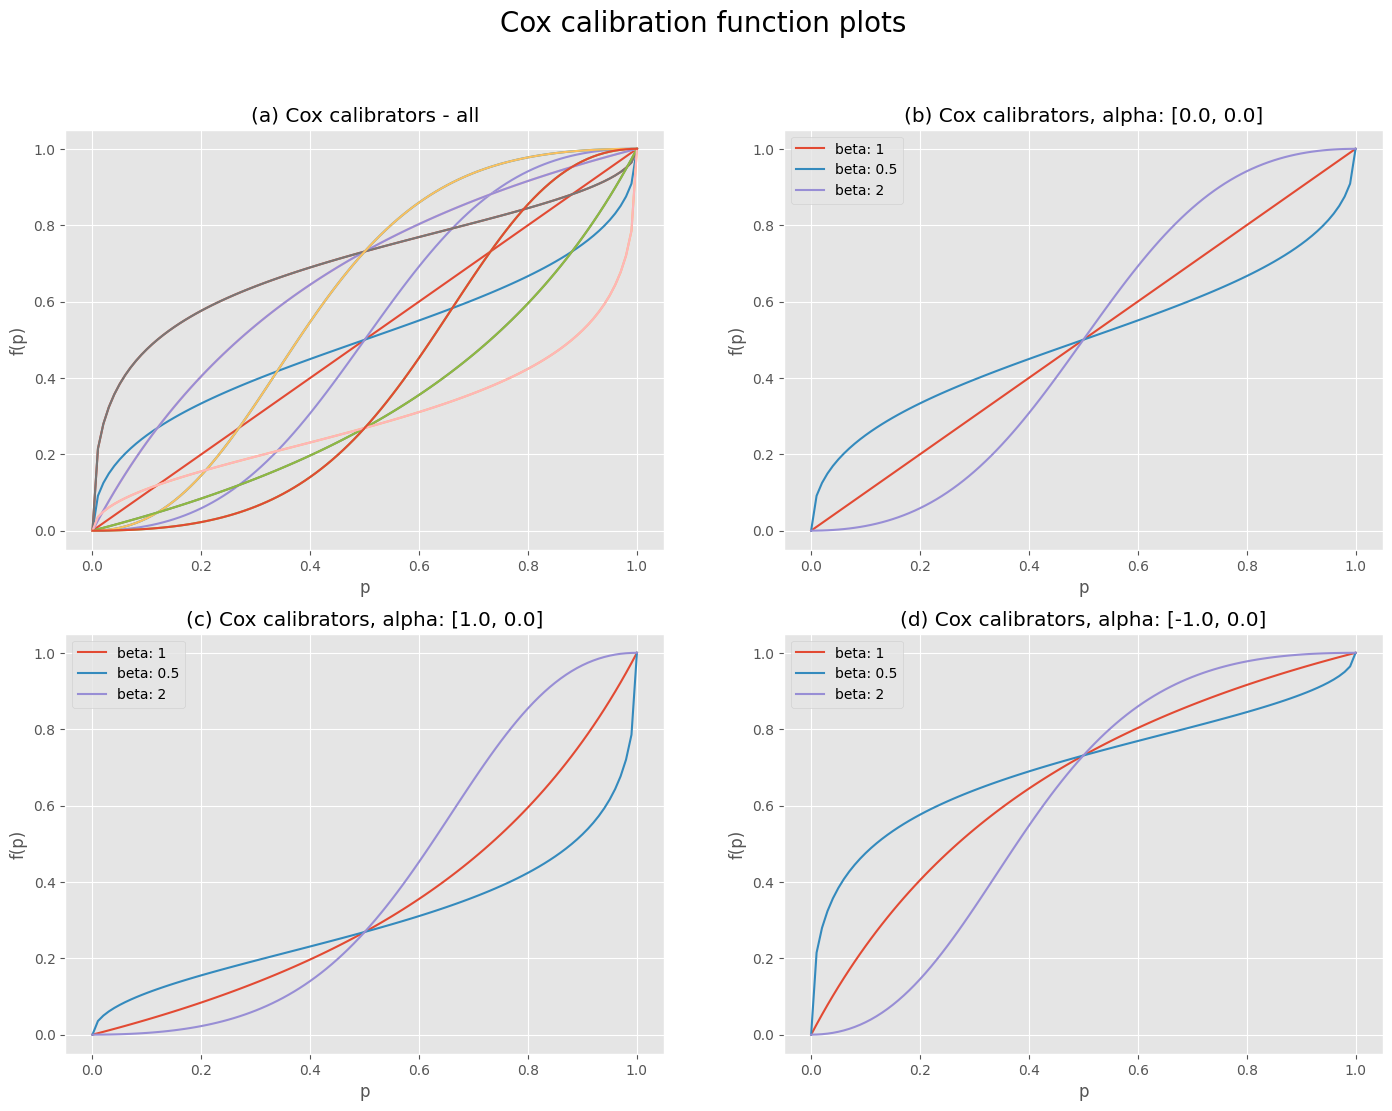

In [142]:
fig, ax = plt.subplots(2, 2, figsize=(17,12))

for ind, calib in enumerate(calibs):
        ax[0,0].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-', label = 'alpha: ' + calib_label[ind][0] + ' beta: ' + calib_label[ind][1])
ax[0,0].set_xlabel('p')
ax[0,0].set_ylabel('f(p)')
ax[0,0].set_title('(a) Cox calibrators - all')

for ind, calib in enumerate(calibs[:3]):
        ax[0,1].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-',  label = 'beta: ' + calib_label[ind][1])
ax[0,1].set_xlabel('p')
ax[0,1].set_ylabel('f(p)')
ax[0,1].set_title('(b) Cox calibrators, alpha: ' + calib_label[ind][0])
ax[0,1].legend()

for ind, calib in enumerate(calibs[3:6]):
        ax[1,0].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-', label = 'beta: ' + calib_label[ind+3][1])
ax[1,0].set_xlabel('p')
ax[1,0].set_ylabel('f(p)')
ax[1,0].set_title('(c) Cox calibrators, alpha: ' + calib_label[ind+3][0])
ax[1,0].legend()

for ind, calib in enumerate(calibs[6:9]):
        ax[1,1].plot(np.linspace(0,1,101), np.array(calib)[:,1], '-', label = 'beta: ' + calib_label[ind+6][1])
ax[1,1].set_xlabel('p')
ax[1,1].set_ylabel('f(p)')
ax[1,1].legend()
ax[1,1].set_title('(d) Cox calibrators, alpha: ' + calib_label[ind+6][0])

plt.suptitle("Cox calibration function plots", fontsize=20)
plt.show()

### Applying Protected classification to an underlying Random Forest classifier

Here we use the Random Forest classifier as the underlying algorithm to which we apply Protected Calibration in the "online mode", i.e. to the test set, trying to protect the classifier against dataset shift (without having to retrain it)

In [143]:
pc = ProtectedClassification(estimator=clf)
p_prime, stats = pc.predict_proba(X_test, y_test, return_stats=True)
y_prime = pc.predict(X_test, y_test)

### ROC/AUC and calibration comparison

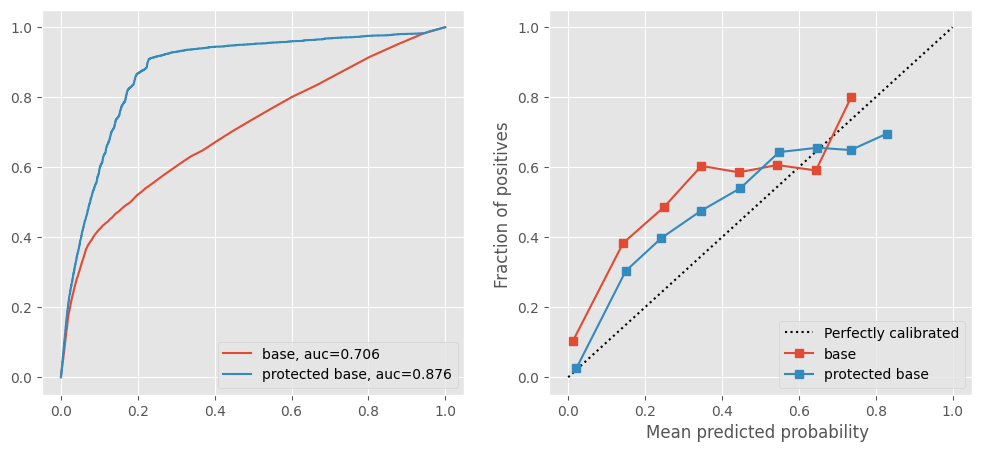

In [144]:
_ , axs = plt.subplots(1, 2, figsize = (12, 5))

fpr_pred, tpr_pred, thresh_pred = metrics.roc_curve(y_test, p_pred[:,1], pos_label=1)
auc_pred = metrics.roc_auc_score(y_test, p_pred[:,1])
axs[0].plot(fpr_pred,tpr_pred,label="base, auc="+str(np.around(auc_pred,decimals=3)))

fpr_prime, tpr_prime, thresh_prime = metrics.roc_curve(y_test, p_prime[:,1], pos_label=1)
auc_prime = metrics.roc_auc_score(y_test, p_prime[:,1])
axs[0].plot(fpr_prime,tpr_prime,label="protected base, auc="+str(np.around(auc_prime,decimals=3)))
axs[0].legend()

prob_true, prob_pred = calibration_curve(y_test, p_pred[:,1], n_bins=10)
cal_display_pred = CalibrationDisplay(prob_true, prob_pred, y_test)
cal_display_pred.plot(ax = axs[1], name='base')
prob_true, prob_pred = calibration_curve(y_test, p_prime[:,1], n_bins=10)
cal_display_prime = CalibrationDisplay(prob_true, prob_pred, y_test)
cal_display_prime.plot(ax = axs[1], name='protected base')
plt.show()

In [152]:
metrics_list = []
metrics_list.append([
    'base', 
    accuracy_score(y_test, y_pred), 
    brier_score_loss(y_test, p_pred[:,1]),
    log_loss(y_test, p_pred)]
    )

metrics_list.append([
    'protected base', 
    accuracy_score(y_test, y_prime), 
    brier_score_loss(y_test, p_prime[:,1]),
    log_loss(y_test, p_prime)]
    )

metrics_df = pd.DataFrame(metrics_list, columns = [
    'classifier', 'accuracy', 'Brier loss', 'log loss'])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)

,accuracy,Brier loss,log loss
classifier,,,
base,0.861,0.118,0.589
protected base,0.871,0.091,0.363


The protected classifier achieves slightly higher accuracy and lower Brier and log loss

## A closer look at the Cox calibrator

Using the ***return_stats*** option we can etraact the weigths given to the individual Cox calibators by the Protected classification algorithm

In [147]:
cox_weights = pd.DataFrame(stats['active_weight'])
cox_weights.columns = ['alpha: ' + i[0] + ' beta: ' + i[1] for i in calib_label]
cox_weights.index = ['j rate: 10E-2', 'j rate: 10E-3', 'j rate: 10E-4']
cox_weights

,"alpha: [0.0, 0.0] beta: 1","alpha: [0.0, 0.0] beta: 0.5","alpha: [0.0, 0.0] beta: 2","alpha: [1.0, 0.0] beta: 1","alpha: [1.0, 0.0] beta: 0.5","alpha: [1.0, 0.0] beta: 2","alpha: [-1.0, 0.0] beta: 1","alpha: [-1.0, 0.0] beta: 0.5","alpha: [-1.0, 0.0] beta: 2","alpha: [0.0, 1.0] beta: 1","alpha: [0.0, 1.0] beta: 0.5","alpha: [0.0, 1.0] beta: 2","alpha: [0.0, -1.0] beta: 1","alpha: [0.0, -1.0] beta: 0.5","alpha: [0.0, -1.0] beta: 2"
j rate: 10E-2,4.860253e-63,6.298276e-63,4.185108e-63,4.101952e-63,4.389124e-63,3.863991e-63,6.399375e-63,7.878189e-61,5.118301e-63,6.399375e-63,7.878189e-61,5.118301e-63,4.101952e-63,4.389124e-63,3.863991e-63
j rate: 10E-3,2.857456e-04,3.704600e-04,2.459301e-04,2.410203e-04,2.579461e-04,2.269751e-04,3.763439e-04,4.721234e-01,3.009782e-04,3.763439e-04,4.721234e-01,3.009782e-04,2.410203e-04,2.579461e-04,2.269751e-04
j rate: 10E-4,1.571358e-06,2.037303e-06,1.352339e-06,1.325328e-06,1.418429e-06,1.248061e-06,2.069631e-06,2.601212e-02,1.655158e-06,2.069631e-06,2.601212e-02,1.655158e-06,1.325328e-06,1.418429e-06,1.248061e-06


We can see that the largest weights of Protected classification algorithm are given to the **alpha: [0.0, 1.0] beta: 0.5** Cox calibrator

In [148]:
ind = np.argmax(pd.DataFrame(stats['active_weight']).mean(axis=0))
ind

10

calibs[10]

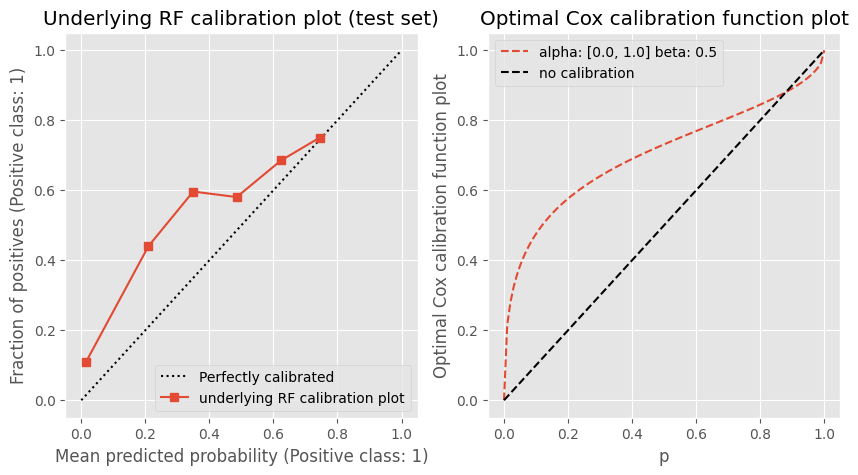

In [109]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[1].plot(np.linspace(0,1,101), np.array(calibs[ind])[:,1], '--', label = 'alpha: ' + calib_label[ind][0] + ' beta: ' + calib_label[ind][1])
axs[1].plot(np.linspace(0,1,101), np.array(calibs[0])[:,1], '--', label = 'no calibration', color = 'k')
display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=7,
            name='underlying RF calibration plot',
            ax=axs[0]
        )
axs[1].set_title("Optimal Cox calibration function plot")
axs[1].set_xlabel("p")
axs[1].set_ylabel("Optimal Cox calibration function plot")
axs[0].set_title("Underlying RF calibration plot (test set)")
plt.legend()
plt.show()

We can see that the largest weight is given to the Cox calibrator which is gthe morror image of the underling RF classifier calibration plot

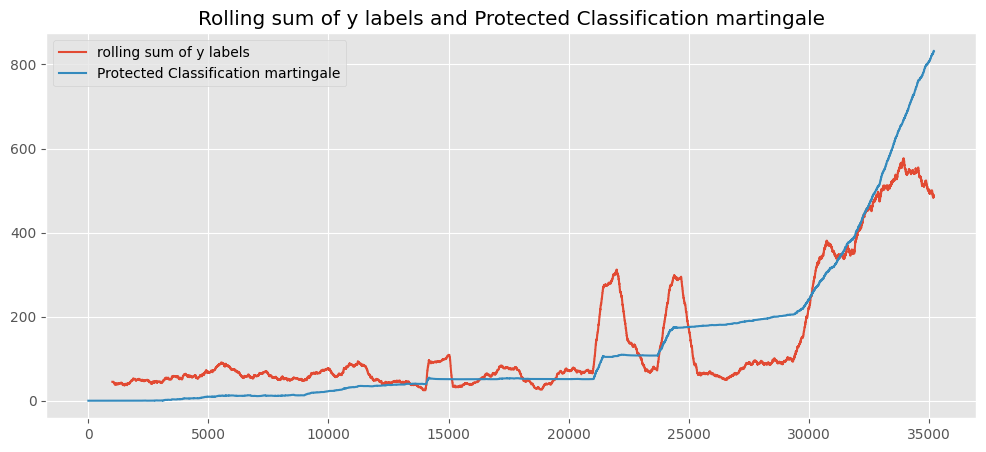

In [101]:
fig, axs = plt.subplots(figsize=(12,5))
axs.plot(pd.DataFrame(y_test).rolling(1000).sum(), label='rolling sum of y labels')
axs.plot(stats['log_scj_martingale'], label =  'Protected Classification martingale')
axs.set_title('Rolling sum of y labels and Protected Classification martingale')
axs.legend()
plt.show()

We can see that the resulting Protetced classification martingale (a function betting against no change in the underlying data distribution from the training set) responds when the underlying y-label distribution changes

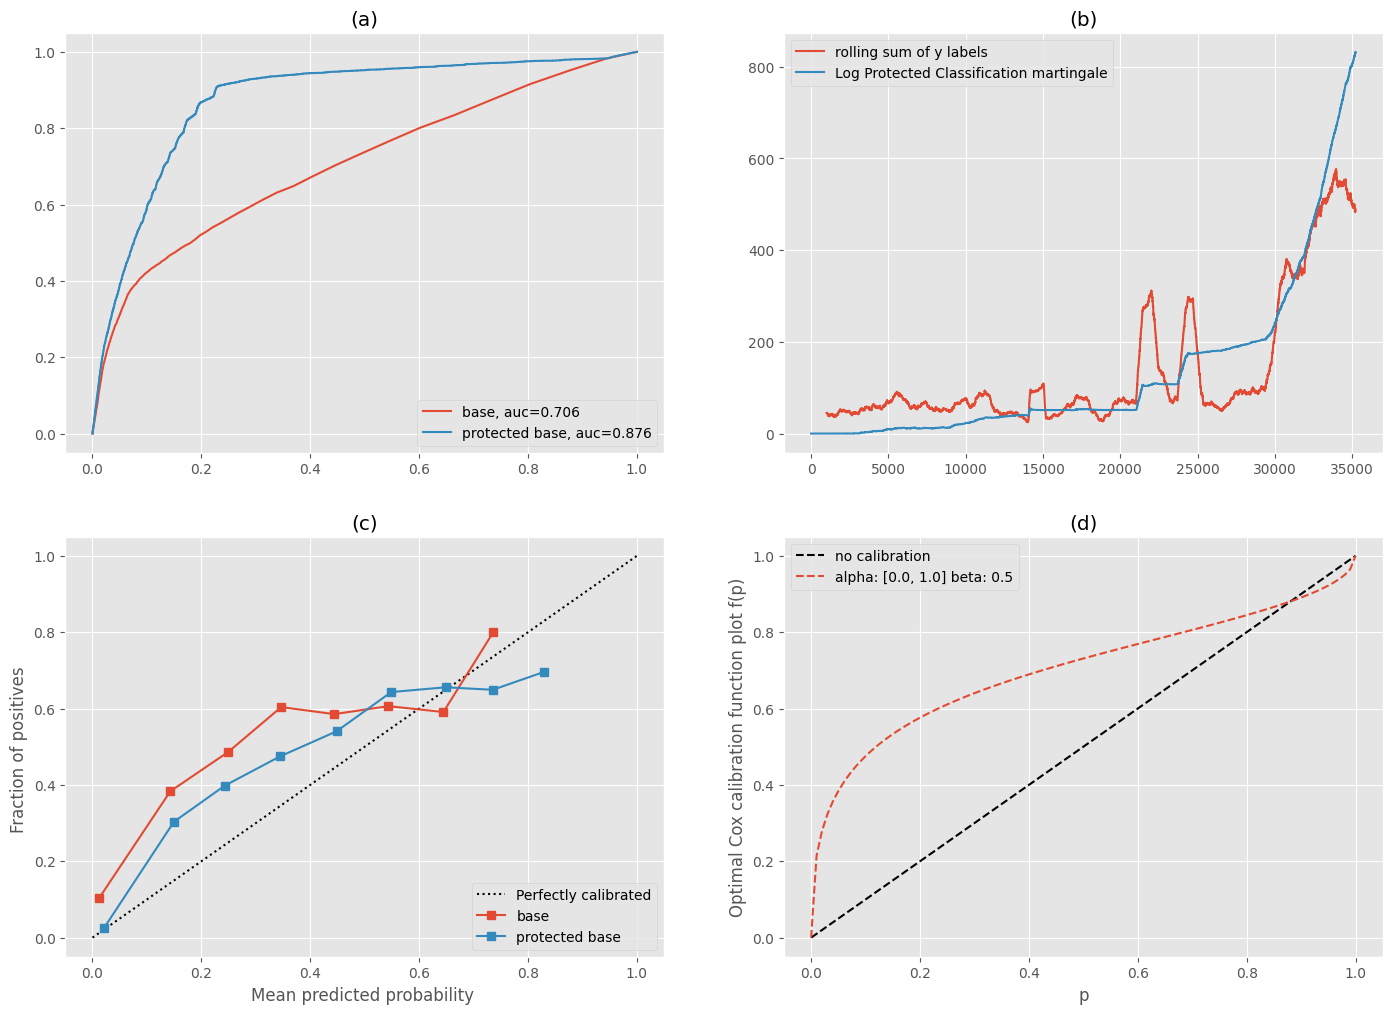

In [150]:
fig, ax = plt.subplots(2, 2, figsize=(17,12))


ax[0,0].plot(fpr_pred,tpr_pred,label="base, auc="+str(np.around(auc_pred,decimals=3)))
ax[0,0].plot(fpr_prime,tpr_prime,label="protected base, auc="+str(np.around(auc_prime,decimals=3)))
ax[0,0].legend()
ax[0,0].set_title('(a)')

ax[0,1].plot(pd.DataFrame(y_test).rolling(1000).sum(), label='rolling sum of y labels')
ax[0,1].plot(stats['log_scj_martingale'], label =  'Log Protected Classification martingale')
ax[0,1].legend()
ax[0,1].set_title('(b)')

cal_display_pred.plot(ax = ax[1,0], name='base')
cal_display_prime.plot(ax = ax[1,0], name='protected base')
ax[1,0].set_title('(c)')

ax[1,1].plot(np.linspace(0,1,101), np.array(calibs[0])[:,1], '--', label = 'no calibration', color = 'k')
ax[1,1].plot(np.linspace(0,1,101), np.array(calibs[ind])[:,1], '--', label = 'alpha: ' + calib_label[ind][0] + ' beta: ' + calib_label[ind][1])
ax[1,1].set_xlabel("p")
ax[1,1].set_ylabel("Optimal Cox calibration function plot f(p)")
ax[1,1].set_title('(d)')
ax[1,1].legend()

plt.show()